# Analysis - exp62 - 72, or more

- Have run a few tuning experiments for the `(s,a) -> v` representation of wythoffs.
- In this notebook I compare the best of these head to head.

In [1]:
import os
import csv

import optuna
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms

import numpy as np
import pandas as pd

from glob import glob
from pprint import pprint
from copy import deepcopy

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

matplotlib.rcParams.update({'font.size': 16})
matplotlib.rc('axes', titlesize=16)

from notebook_helpers import load_params
from notebook_helpers import load_monitored
from notebook_helpers import join_monitored
from notebook_helpers import score_summary

def load_data(path, model, run_index=None):
    runs = range(run_index[0], run_index[1]+1)
    exps = []
    for r in runs:
        file = os.path.join(path, f"run_{model}_{r}_monitor.csv".format(int(r)))
        try:
            mon = load_monitored(file)
        except FileNotFoundError:
            mon = None
        exps.append(mon)
    return exps

def load_hp(name):
    return pd.read_csv(name, index_col=False)

def find_best(hp, data, window, score="score"):
    scores = []
    for r, mon in enumerate(data):
        if mon is not None:
            full = mon[score]
            selected = full[window[0]:window[1]]
            x = np.mean(selected)
            scores.append(x)
        else:
            scores.append(np.nan)
    best = np.nanargmax(scores)

    return scores[best], hp[best:best+1]

def find_worst(hp, data, window, score="score"):
    scores = []
    for r, mon in enumerate(data):
        if mon is not None:
            full = mon[score]
            selected = full[window[0]:window[1]]
            x = np.mean(selected)
            scores.append(x)
        else:
            scores.append(np.nan)
    best = np.nanargmin(scores)
    return scores[worst], hp[best:best+1]

# HP

## Grid search

- exp68 as the best. 

In [2]:
path = "/Users/qualia/Code/azad/data/wythoff/exp68/"
hp = load_hp(os.path.join(path,"grid.csv"))

# Find the best model + hp
models = ["DQN_xy1", "DQN_xy2", "DQN_xy3", "DQN_xy4", "DQN_xy5"]
index = (0, 250)
for model in models:
    data = load_data(path, model, run_index=index)
    score, best_hp = find_best(hp, data, (200,250))
    print(f"{model} - {score}:\n{best_hp}\n---")

DQN_xy1 - 0.29417067320374646:
     row_code  device_code  epsilon  gamma  learning_rate
189       189            1      0.1    0.4        0.19949
---
DQN_xy2 - 0.22569482901968993:
    row_code  device_code  epsilon  gamma  learning_rate
25        25            1      0.1    0.1       0.128776
---
DQN_xy3 - 0.3995033689945446:
     row_code  device_code  epsilon  gamma  learning_rate
155       155            3      0.1    0.4       0.027755
---
DQN_xy4 - 0.3035457374237523:
    row_code  device_code  epsilon  gamma  learning_rate
85        85            1      0.1    0.2       0.179286
---
DQN_xy5 - 0.16227355079411332:
    row_code  device_code  epsilon  gamma  learning_rate
35        35            3      0.1    0.1       0.179286
---


## Optuna

- exp71 was the best

In [3]:
path = "/Users/qualia/Code/azad/data/wythoff/exp71/"

# Load the optuna study object, and extract the interesting bits
study = torch.load(os.path.join(path, "run_0.torch"))

In [63]:
study.trials_dataframe().sort_values("value", ascending=False).head(1)

,number,value,datetime_start,datetime_complete,duration,params_0,params_1,params_2,params_3,params_4,params_5,params_epsilon,params_gamma,params_learning_rate,params_n_layers,state
97,97,0.281767,2020-05-16 22:28:48.427779,2020-05-16 22:36:20.469986,00:07:32.042207,10,11,13.0,NaN,NaN,NaN,0.333343,0.273944,0.496927,3,COMPLETE


In [5]:
study.best_value

0.2817669048809469

In [6]:
study.best_params

{'n_layers': 3,
 '0': 10,
 '1': 11,
 '2': 13,
 'learning_rate': 0.4969268428262877,
 'gamma': 0.2739438715253703,
 'epsilon': 0.3333432601765242}

In [50]:
# Build network for optuna
in_features = 4  # Initial
out_features = [10, 11, 13]
layers = []
for out_feature in out_features:
    layers.append(nn.Linear(in_features, out_feature))
    layers.append(nn.ReLU())
    in_features = deepcopy(out_feature)

# Output layer topo is fixed
layers.append(nn.Linear(in_features, 1))

# Define the nn
class DQN_optuna(nn.Module):
    def __init__(self):
        super(DQN_optuna, self).__init__()
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [54]:
print(DQN_optuna())

DQN_optuna(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=11, bias=True)
    (3): ReLU()
    (4): Linear(in_features=11, out_features=13, bias=True)
    (5): ReLU()
    (6): Linear(in_features=13, out_features=1, bias=True)
  )
)


# Head2Head 

- Compare these two best solutions on the same task and seed.  

In [59]:
from azad.exp.alternatives import wythoff_dqn2
seed_value = 1387
num_episodes = 2500
game = 'Wythoff15x15'
batch_size = 50
memory_capacity = 1e3
anneal = True
update_every = 10
double = True
clip_grad = True
monitor = ('episode', 'loss', 'score', 'Q', 'prediction_error', 'advantage', 'epsilon_e')

### Run

In [60]:
# Grid
result1 = wythoff_dqn2(
    epsilon=0.1,
    gamma=0.4,
    learning_rate=0.027755,
    network='DQN_xy3',
    game=game,
    num_episodes=num_episodes,
    batch_size=batch_size,
    memory_capacity=memory_capacity,
    anneal=anneal,
    update_every=update_every,
    double=double,
    clip_grad=clip_grad,
    seed=seed_value,
    monitor=monitor
)

In [61]:
# Optuna
result2 = wythoff_dqn2(
    epsilon=0.33,
    gamma=0.27,
    learning_rate=0.49,
    network=DQN_optuna,
    game=game,
    num_episodes=num_episodes,
    batch_size=batch_size,
    memory_capacity=memory_capacity,
    anneal=anneal,
    update_every=update_every,
    double=double,
    clip_grad=clip_grad,
    seed=seed_value,
    monitor=monitor,
)

### Visualize

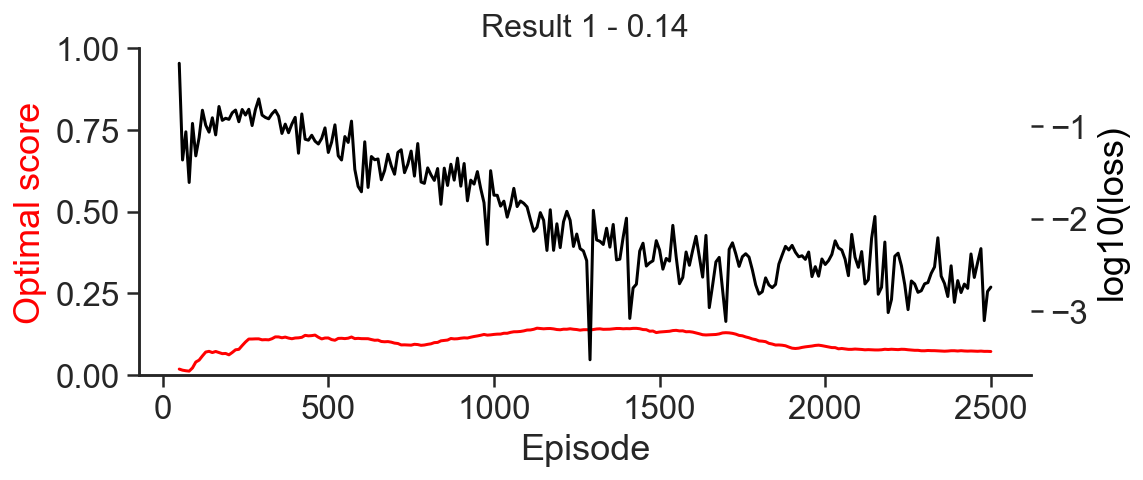

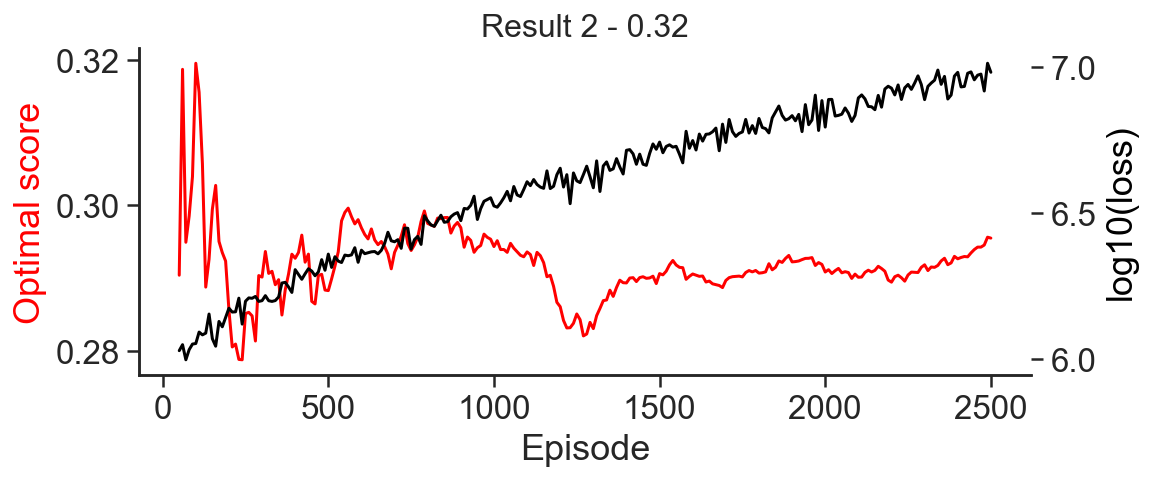

In [62]:
# ---
mon = result1["monitored"]
fig, ax1 = plt.subplots(figsize=(8,3))
_ = ax1.plot(mon['episode'], mon['score'], color='red', alpha=1)
_ = plt.title(f"Result 1 - {np.max(mon['score']).round(2)}")
_ = ax1.set_ylabel("Optimal score", color="red")
_ = ax1.set_xlabel("Episode")
_ = ax1.set_ylim(0, 1)

_ = ax2 = ax1.twinx()                      
_ = ax2.plot(mon['episode'], np.log10(mon['loss']), color='black', alpha=1)
_ = ax2.tick_params(axis='y')             
_ = ax2.set_ylabel('log10(loss)', color="black")
sns.despine()
             
# ---              
mon = result2["monitored"]
fig, ax1 = plt.subplots(figsize=(8,3))
_ = ax1.plot(mon['episode'], mon['score'], color='red', alpha=1)
_ = plt.title(f"Result 2 - {np.max(mon['score']).round(2)}")
_ = ax1.set_ylabel("Optimal score", color="red")
_ = ax1.set_xlabel("Episode")
_ = ax1.set_ylim(0, 1)
_ = ax2 = ax1.twinx()                      
_ = ax2.plot(mon['episode'], np.log10(mon['loss']), color='black', alpha=1)
_ = ax2.tick_params(axis='y')             
_ = ax2.set_ylabel('log10(loss)', color="black")
sns.despine()